# Factor Analysis

The factor analysis model can be seen as several things at the same time:
* It is a gaussian mixture model
* It is a dimensionality reduction technique
* It can be seen as a matrix factorization technique

The basic model itself is simple to write down:
$$
\newcommand{bfvec}[1]{{\bf #1}}
p(\bfvec{x_i}\;|\;\bfvec{z_i},\bfvec{\theta})=\mathcal{N}(\bfvec{W}\cdot\bfvec{z_i}+\bfvec{\mu},\bfvec{\Psi})$$
where $\bfvec{W}$ is a D$\times$L matrix, known as **factor loading matrix**, and $\bfvec{\Psi}$ is a D$\times$D covariance matrix.

The $\bfvec{z_i}$ are latent variables with $\bfvec{z_i}\in \mathbb{R}^L$. The $\bfvec{x_i}$ are $\bfvec{x_i}\in \mathbb{R}^D$. The index $i$ is indexing the observations. Basically for every "visible" observation vector $\bfvec{x_i}$ of dimension D there is an associated "hidden" or "latent" vector $\bfvec{z_i}$ of dimension L (with $L<D$ for dimensionality reduction).

We take $\bfvec{\Psi}$ to be diagonal, since the whole point of the model is to “force” $\bfvec{z_i}$ to explain
the correlation, rather than "baking it in" to the observation's covariance. This overall model
is called **factor analysis** or **FA**. The special case in which $\bfvec{\Psi}=\sigma^2\bfvec{I}$ is called **probabilistic principal components analysis** or **PPCA**.

You can find more information in chapter 12.1 "Factor analysis" of [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020).

## References

The following examples are a mix of the following three different blog posts:
* [How to do factor analysis](https://blog.dominodatalab.com/how-to-do-factor-analysis) by [Nick Elprin](https://blog.dominodatalab.com/author/nick): this uses the standard R 'Psych' package.
* [Fitting a Bayesian Factor Analysis Model in Stan](https://rfarouni.github.io/assets/projects/BayesianFactorAnalysis/BayesianFactorAnalysis.html) by [Rick Farouni](http://rfarouni.github.io): replicates the model in Stan.
* [Probabilistic Factor Analysis Methods](https://www.cs.helsinki.fi/u/sakaya/tutorial) by [Suleiman A. Khan](https://users.ics.aalto.fi/suleiman/) & [Joseph H. Sakaya](https://www.cs.helsinki.fi/en/people/sakaya): uses the ADVI ([Automatic Variational Inference in Stan](https://arxiv.org/abs/1506.03431)) inference method rather than MCMC sampling and combines the model with ARD (Automatic Relevance Determination, see chapter 13.7 "Automatic relevance determination (ARD)/sparse Bayesian learning (SBL)" of [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020)) to automatically detect the number of latent dimensions.

Let's start with several imports. There are so many, because each example requires its own imports.

## Standard python imports

In [1]:
%%capture
%matplotlib inline
import locale
locale.setlocale(locale.LC_ALL, 'C')
import os, timeit, collections

import IPython.display

import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.linalg, pandas as pd, \
    matplotlib.pyplot as plt, matplotlib.dates, xarray as xr, seaborn as sns
    
import readline # https://github.com/ContinuumIO/anaconda-issues/issues/152
%load_ext rpy2.ipython
import rpy2, rpy2.rinterface, rpy2.robjects, rpy2.robjects.packages, rpy2.robjects.lib, rpy2.robjects.lib.grid, \
    rpy2.robjects.lib.ggplot2, rpy2.robjects.pandas2ri, rpy2.interactive.process_revents, \
    rpy2.interactive, rpy2.robjects.lib.grdevices
# rpy2.interactive.process_revents.start()
rpy2.robjects.pandas2ri.activate()

import pymc3 as pm
from theano import tensor as tt
import pystan, pystan.external.pymc.plots

import datetime, time, pytz, dateutil.relativedelta

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=8)
np.core.arrayprint._line_width = 180

sns.set()

SEED = 42
np.random.seed(SEED)

## R imports

As next step let's import some R packages that we will need.

In [2]:
# import R's "base" package
base = rpy2.robjects.packages.importr('base')
# import R's utility package
utils = rpy2.robjects.packages.importr('utils')
# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('psych', 'GPArotation')

# R vector of strings

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpy2.robjects.packages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(rpy2.robjects.StrVector(names_to_install))

In [3]:
grdevices = rpy2.robjects.packages.importr('grDevices')
grdevices

rpy2.robjects.packages.Package as a <module 'grDevices'>

In [4]:
psych = rpy2.robjects.packages.importr('psych')
psych

rpy2.robjects.packages.Package as a <module 'psych'>

In [5]:
gparotation = rpy2.robjects.packages.importr('GPArotation')
gparotation

rpy2.robjects.packages.Package as a <module 'GPArotation'>

## Sample data generation

The concrete simulated data example that I will try to reverse engineer via the above three methods is from [Fitting a Bayesian Factor Analysis Model in Stan](https://rfarouni.github.io/assets/projects/BayesianFactorAnalysis/BayesianFactorAnalysis.html) by [Rick Farouni](http://rfarouni.github.io).

In [6]:
def build_toy_dataset(N=300):
    D=10
    K=3
    mu_z    = np.zeros(K) # the mean of theta
    sigma_z = np.diag(np.ones(K))

    mu_epsilon = np.zeros(D) # the mean of epsilon
    psi = np.diag([0.2079, 0.19, 0.1525, 0.20, 0.36, 0.1875, 0.1875, 1.00, 0.27, 0.27])

    l1  = np.array([0.99, 0.00, 0.25, 0.00, 0.80, 0.00, 0.50, 0.00, 0.00, 0.00]).reshape(-1,1)
    l2  = np.array([0.00, 0.90, 0.25, 0.40, 0.00, 0.50, 0.00, 0.00, -0.30, -0.30]).reshape(-1,1)
    l3  = np.array([0.00, 0.00, 0.85, 0.80, 0.00, 0.75, 0.75, 0.00, 0.80, 0.80]).reshape(-1,1)
    L = np.hstack([l1, l2, l3]) # size(10,3)

    # sample factor scores # size(K,N) = size(3,N)
    Z   = np.random.multivariate_normal(mu_z, sigma_z, size=N).T  
    # sample error vector # size(D,N) = size(10,N)
    epsilon = np.random.multivariate_normal(mu_epsilon, psi, size=N).T

    X = np.dot(L, Z) + epsilon  # generate observable data # size(D,N) = size(10,N)
    return X, L, Z

# build_toy_dataset(N=12) # size(10,12)

In [7]:
X, L,_ = build_toy_dataset()

df = pd.DataFrame(X.T, columns=['x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10'])
df.head()

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
0,0.5789,-0.7172,1.4849,0.4836,0.1614,0.6961,1.0573,0.3687,1.2239,0.5746
1,1.4643,0.0542,0.1990,-0.1562,1.3499,-0.4860,0.6667,-0.3078,0.7026,0.0125
2,2.1083,0.4471,0.1619,-0.7498,0.6475,0.7095,0.6008,1.0736,-0.9696,-0.5367
3,0.7378,-0.8622,-0.5964,-0.7825,1.5627,-0.4754,0.2287,-0.5552,-1.3761,-0.9860
4,1.0815,-2.3869,-1.7890,-2.6238,0.7170,-2.2701,-1.4723,-1.2803,-0.8575,-0.4681


In [8]:
rdf = rpy2.robjects.pandas2ri.py2ri(df)
# print(rdf)

## Factor analysis via the R 'psych' package

The "standard" way to proceed in factor analysis is to first determin the number of factors for the latent space via a so called "scree plot" and then perform the factor analysis based on this number as input.

Because we simulated the data by hand we know that the number of latent factors (the dimension of the latent space) is 3. Let's see what the "scree plot" says:

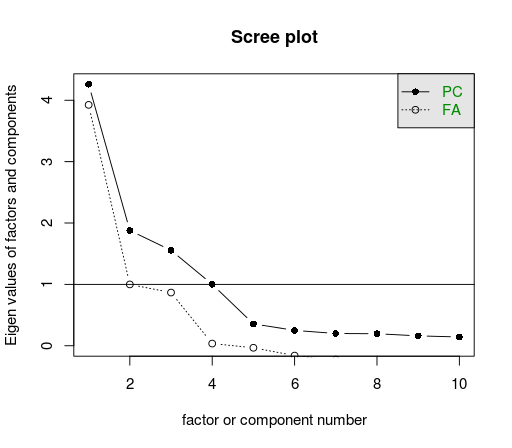

In [9]:
# scree_plot = psych.scree(rdf)
with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=512, height=448, res=90) as img:
    psych.scree(rdf)
    #rpy2.robjects.r.print(scree_plot)   
IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

As we are performing factor analysis (FA) and not Principal Component Analysis (PA) we have to take the empty dots. This would tell us that there are 2 factors rather than 3, which is wrong.

There is a better way than the scree plot to determin the number of factors, which is called "parallel analysis". In principle it should work as follows, but currently it hangs on my machine. I had it already working and it says that there are 3 factors, which is the correct value:

In [10]:
#with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=512, height=448, res=90) as img:
#    psych.fa_parallel(rdf)
#IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

Now imagine we know the number of factors, 3, and want to perform the factor analysis. With the R psych package this works as follows:

In [11]:
result = psych.fa(rdf, nfactors=rpy2.robjects.IntVector([3]), fm='minres', rotate='oblimin') # rotate='varimax'

And from the result we can extract the loadings as follows:

In [12]:
loadings = np.array(result[result.names.index('loadings')]).reshape(10,3)
loadings

array([[ 0.00544034,  0.90369275,  0.00354366],
       [ 0.03402593,  0.02093004,  0.90616737],
       [ 0.8980303 ,  0.13397521,  0.10373306],
       [ 0.81270743, -0.11026588,  0.3307561 ],
       [-0.00280862,  0.7325404 ,  0.03212513],
       [ 0.79762678, -0.10924608,  0.4071758 ],
       [ 0.79494239,  0.40091209, -0.08089782],
       [-0.06234762,  0.0058739 ,  0.04540959],
       [ 0.80832087, -0.13629152, -0.39046584],
       [ 0.80171872, -0.09195148, -0.34299993]])

Comparing this to the values of our original L matrix we see that column 0 of the loadings result corresponds to column 2 of the L matrix. Column 1 of the loadings matrix corresponds somehow to column 0 of the L matrix. And column 2 of the loadings matrix corresponds to column 1 of the L matrix.

In [13]:
L

array([[ 0.99,  0.  ,  0.  ],
       [ 0.  ,  0.9 ,  0.  ],
       [ 0.25,  0.25,  0.85],
       [ 0.  ,  0.4 ,  0.8 ],
       [ 0.8 ,  0.  ,  0.  ],
       [ 0.  ,  0.5 ,  0.75],
       [ 0.5 ,  0.  ,  0.75],
       [ 0.  ,  0.  ,  0.  ],
       [ 0.  , -0.3 ,  0.8 ],
       [ 0.  , -0.3 ,  0.8 ]])

### Evaluation of the result

In factor analysis you have 2 tasks. The first task is to find the latent linear sub-space. The second task is to find an orientation (rotation) of the coordinate system in this linear sub-space that you consider as "good".

For our purpose here the rotation is less relevant, but it matters for human interpretability.

An orthogonal rotation assumes that the factors are uncorrelated, while an oblique rotation assumes they are correlated. The choice between orthogonal vs. oblique choice depends on your particular use-case. If your data consists of items from one large domain and you have no reason to think that certain behaviors could be completely uncorrelated, use oblique rotation. If you want to know more, see [Factor Rotations in Factor Analyses](http://www.utdallas.edu/~herve/Abdi-rotations-pretty.pdf) by Hervé Abdi for a brief overview, or [Choosing the Right Type of Rotation in PCA and EFA](http://hosted.jalt.org/test/PDF/Brown31.pdf) for a little more depth.

Two popular types of rotation are Varimax (orthogonal), and Oblimin (oblique).

Independent of rotation, how would you evaluate how close the identified `loadings` subspace is compared to our input matrix `L`?

As we work with mean zero data, we know that both sub-spaces pass through the coordinate system origin.

In 3 dimensions, if you would want to compare how closely two 2-dimensional planes match each other you could use the angle between their normal vectors as a measure of similarity. If this angle is 0° the planes match completely. If this angel is 90° the planes are orthogonal to on eachother.

#### Principal angles / angles between flats

It turns out that this idea can be extended to higher dimensional spaces and it is called [Principal_angles](http://en.wikipedia.org/wiki/Principal_angles) or "angles between flats". I've found an implementation in the [PyPhysim](https://github.com/darcamo/pyphysim) package: [pyphysim.subspace.metrics](http://pyphysim.readthedocs.io/en/latest/_modules/pyphysim/subspace/metrics.html). You can find more details in the paper [Principal Angles Between Subspaces and Their Tangents](https://www.merl.com/publications/docs/TR2012-058.pdf) and here is some [matlab code](https://sensblogs.wordpress.com/2011/09/07/matlab-codes-for-principal-angles-also-termed-as-canonical-correlation-between-any-arbitrary-subspaces-redirected-from-jen-mei-changs-dissertation/).

In [14]:
def calc_principal_angles(matrix1, matrix2):
    """
    Calculates the principal angles between `matrix1` and `matrix2`.

    Parameters
    ----------
    matrix1 : np.ndarray
        A 2D numpy array.
    matrix2 : np.ndarray
        A 2D numpy array.

    Returns
    -------
    np.ndarray
        The principal angles between `matrix1` and `matrix2`. This is a
        1D numpy array.

    See also
    --------
    calc_chordal_distance_from_principal_angles

    Examples
    --------
    >>> A = np.array([[1, 2], [3, 4], [5, 6]])
    >>> B = np.array([[1, 5], [3, 7], [5, -1]])
    >>> print(calc_principal_angles(A, B))
    [ 0.          0.54312217]
    """
    # First we need to find the orthogonal basis for matrix1 and
    # matrix2. This can be done with the QR decomposition. Note that if
    # matrix1 has 'n' columns then its orthogonal basis is given by the
    # first 'n' columns of the 'Q' matrix from its QR decomposition.
    Q1 = np.linalg.qr(matrix1)[0]
    Q2 = np.linalg.qr(matrix2)[0]

    # TODO: Test who has more columns. Q1 must have dimension grater than
    # or equal to Q2 so that the SVD can be calculated in the order below.
    #
    # See the algorithm in
    # http://sensblogs.wordpress.com/2011/09/07/matlab-codes-for-principal-angles-also-termed-as-canonical-correlation-between-any-arbitrary-subspaces-redirected-from-jen-mei-changs-dissertation/
    S = np.linalg.svd(
        Q1.conjugate().transpose().dot(Q2), full_matrices=False)[1]

    # The singular values of S vary between 0 and 1, but due to
    # computational impressions there can be some value above 1 (by a very
    # small value). Below we change values greater then 1 to be equal to 1
    # to avoid problems with the arc-cos call later.
    S[S > 1] = 1  # Change values greater then 1 to 1

    # The singular values in the matrix S are equal to the cosine of the
    # principal angles. We can calculate the arc-cosine of each element
    # then.
    return np.arccos(S)

Let's check the implementation with the example given in the documentation string:

In [15]:
A = np.array([[1, 2], [3, 4], [5, 6]])
A

array([[1, 2],
       [3, 4],
       [5, 6]])

In [16]:
B = np.array([[1, 5], [3, 7], [5, -1]])
B

array([[ 1,  5],
       [ 3,  7],
       [ 5, -1]])

In [17]:
calc_principal_angles(A, B)

array([ 0.        ,  0.54312217])

If you want to have the values in ° rather than radians you have to convert the values as follows:

In [18]:
180.0*calc_principal_angles(A, B)/np.pi

array([  0.        ,  31.11860813])

The number of angles equal to zero is the dimension of the space where the two subspaces intersect. The smaller the angeles the closer the two subspaces are to each other. Let's see what we get for our `loadings` matrix and the known `L` matrix:

In [19]:
180.0*calc_principal_angles(L, loadings)/np.pi

array([ 1.25416364,  2.61024744,  4.68821628])

#### Grassmanian norm

Another way to compare how close two sub-spaces are to each other is the [Grassmanian](https://en.wikipedia.org/wiki/Grassmannian) norm. 

Let's first develop a few pre-requisits.

If you have a sub-space defined by a set of vectors $\bfvec{a_i}$ embedded in a higher dimensional space then you can create a matrix out of these column vectors $A=[\bfvec{a_1}, \bfvec{a_2}, ..., \bfvec{a_n}]$ and you say that this sub-space is the **column space** of $A$. In that regard the colum space of our matrix $L$ defines the sub-space in which our data-points lie (plus the noise $\mathcal{N}(\mu,\sigma)$ of course).

If you have an arbitrary vector $\bfvec{b}$ of the full space, how an you project this vector into the column space of A? The full math is described in this lecture on [projections onto subspaces](https://ocw.mit.edu/courses/mathematics/18-06sc-linear-algebra-fall-2011/least-squares-determinants-and-eigenvalues/projections-onto-subspaces/MIT18_06SCF11_Ses2.2sum.pdf), but the code for doing this is here:

In [20]:
def projection_matrix(A):
    inv_AT_A = scipy.linalg.inv(np.dot(A.T, A))
    P = np.dot(np.dot(A, inv_AT_A),A.T)
    return P

As a test, let's take one of the column vectors of $L$ and project it into the column space of $L$. This should leave the column vectors of $L$ unchanged, as it is already part of this sub-space.

In [21]:
L

array([[ 0.99,  0.  ,  0.  ],
       [ 0.  ,  0.9 ,  0.  ],
       [ 0.25,  0.25,  0.85],
       [ 0.  ,  0.4 ,  0.8 ],
       [ 0.8 ,  0.  ,  0.  ],
       [ 0.  ,  0.5 ,  0.75],
       [ 0.5 ,  0.  ,  0.75],
       [ 0.  ,  0.  ,  0.  ],
       [ 0.  , -0.3 ,  0.8 ],
       [ 0.  , -0.3 ,  0.8 ]])

In [22]:
L[:,0]

array([ 0.99,  0.  ,  0.25,  0.  ,  0.8 ,  0.  ,  0.5 ,  0.  ,  0.  ,  0.  ])

In [23]:
 np.dot(projection_matrix(L), L[:,0])

array([ 0.99, -0.  ,  0.25,  0.  ,  0.8 ,  0.  ,  0.5 ,  0.  ,  0.  ,  0.  ])

Which is correct.

As a second ingredient we will the the [operator norm](https://en.wikipedia.org/wiki/Operator_norm), which is defined as:

$$||A||_{op} = \inf\{c\ge0:||Av||\le c||v||\space\hbox{for all}\space v\in V\}$$

This basically says that once you have a norm on vectors then you can produce out of it a norm for matrices (operators).

Finally we can define the Grassmanian norm as follows:

$$d(W, W')=||P_W-P_{W'}||_{op}$$

Which basically says that you use each matrix $W$ and $W'$ as a project matrix and you look how far the points projected into the respective column spaces of $W$ and $W'$ lie apart.

The code for this looks as follows:

In [24]:
def grassmannian_norm(M1, M2, type=2):
    return scipy.linalg.norm(projection_matrix(M1) - projection_matrix(M2), type)

The norm that you take in the vector space does not matter too much and as default we've taken the 2-norm, which means for matrices the largest singular value. 

The reason for this default choice is that in this case the Grassmanian norm is equal to the largest principal angle, which we can verify as follows:

In [25]:
grassmannian_norm(A, B)

0.51681139412170296

Or for comparing our `loadings` matrix and the known `L` matrix:

In [26]:
180.0*grassmannian_norm(L, loadings)/np.pi

4.682986527950983

#### Summary of evaluation of the result

Based on the principal angles and the Grassmanian norm we can say that the R "psych" package did a good job to recover the original sub-plane.